# Модель для прогнозирования оттока клиентов для сервиса доставки кофе

# План работы

## Этап 1. Подготовка среды и библиотек
1. Установите и настройте библиотеки. Для воспроизводимости результатов зафиксируйте версии пакетов в файле `requirements.txt`.

2. Зафиксируйте `random_state`.

3. Загрузите данные из CSV-файла. Путь к файлу: `'/datasets/coffee_churn_dataset.csv'`. Используйте сепаратор `","`, а для чтения чисел с плавающей точкой — параметр `decimal="."`.

In [6]:
# После этой ячейки нужно перезагрузить Kernel
!pip install phik
!pip install category_encoders

# для импорта TargetEncoder
!pip install --upgrade scikit-learn

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, average_precision_score, make_scorer, f1_score
from sklearn.metrics import precision_score, fbeta_score, roc_curve, recall_score, precision_recall_curve
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, train_test_split, GridSearchCV
import joblib
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [8]:
# !pip freeze > requirements.txt

In [9]:
start_df = pd.read_csv('coffee_churn_dataset.csv',
                       sep=',', decimal='.')

In [10]:
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10450 non-null  object 
 1   days_since_last_order     9505 non-null   float64
 2   order_frequency_month     9850 non-null   float64
 3   order_frequency_week      10062 non-null  float64
 4   avg_order_value           9867 non-null   float64
 5   median_order_value        9619 non-null   float64
 6   total_spent_last_month    10156 non-null  float64
 7   total_spent_last_week     9506 non-null   float64
 8   discount_usage_rate       10053 non-null  float64
 9   last_coffee_type          10192 non-null  object 
 10  preferred_roast           10334 non-null  object 
 11  milk_preference           9782 non-null   object 
 12  seasonal_menu_tried       9461 non-null   float64
 13  coffee_bean_origin        9768 non-null   object 
 14  last_d

In [11]:
start_df.sample(10)

,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,...,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
384,user_09324,1.0,NaN,0.923574,2286.310631,703.434553,2639.031061,683.618457,0.349933,arabica,...,0.0,4.659390,4.488858,0.0,summer,24.0,android,0.0,geo_66,0
3938,user_07284,NaN,0.653807,0.217469,NaN,616.908408,464.809046,133.762561,0.410403,arabica,...,1.0,3.264292,NaN,1.0,spring,10.0,android,1.0,geo_32,0
7058,user_08239,0.0,5.542979,1.413754,960.261310,466.883456,2614.788609,793.948443,0.092529,blend,...,1.0,5.177263,6.597110,0.0,autumn,15.0,ios,0.0,geo_2,0
10202,user_03108,4.0,5.485093,1.400185,2947.866201,1287.665298,6614.468186,1448.686290,0.012599,blend,...,1.0,4.684314,2.971364,2.0,spring,4.0,ios,0.0,geo_95,1
7808,user_07789,4.0,5.457758,1.205113,1363.243539,571.707220,3028.071393,801.648636,0.088154,robusta,...,1.0,4.122767,2.510765,3.0,spring,0.0,android,1.0,geo_90,1
3696,user_06562,1.0,9.092128,1.993890,1571.536167,520.216623,5471.155721,1147.687012,0.308320,robusta,...,NaN,4.057772,3.732798,1.0,summer,26.0,ios,0.0,geo_79,0
10236,user_09339,3.0,12.010134,2.682842,695.255003,366.358459,4030.537223,1228.736340,0.088320,blend,...,1.0,4.435544,2.132209,0.0,spring,9.0,android,0.0,geo_2,0
7517,user_07129,NaN,2.900869,0.618774,564.119156,218.761839,NaN,174.032316,0.519620,arabica,...,1.0,4.145352,4.995484,0.0,summer,9.0,NaN,0.0,geo_1,0
4404,user_09569,8.0,1.588639,0.484543,1554.625700,813.443179,1296.671636,477.367021,0.247220,arabica,...,1.0,5.043504,4.438155,2.0,spring,8.0,ios,1.0,geo_73,0
2272,user_05584,3.0,5.846898,1.350474,608.598262,432.894003,2571.749012,409.463901,0.337879,arabica,...,1.0,3.779726,4.545037,1.0,summer,40.0,ios,0.0,geo_96,0


In [12]:
# Проверка что пользователи уникальные
print(f"Количество уникальных пользователей: {len(start_df['user_id'].unique())}\n")

print('Доля пустых значений по столбцам:')
for column in start_df.columns:
    print(f"{column}:{(1 - start_df[column].notna().sum() / start_df.shape[0]) * 100:.2f}%")

Количество уникальных пользователей: 10450

Доля пустых значений по столбцам:
user_id:0.00%
days_since_last_order:9.04%
order_frequency_month:5.74%
order_frequency_week:3.71%
avg_order_value:5.58%
median_order_value:7.95%
total_spent_last_month:2.81%
total_spent_last_week:9.03%
discount_usage_rate:3.80%
last_coffee_type:2.47%
preferred_roast:1.11%
milk_preference:6.39%
seasonal_menu_tried:9.46%
coffee_bean_origin:6.53%
last_drink_size:4.82%
subscription_status:8.98%
app_opens_per_week:8.57%
notifications_enabled:5.14%
review_rating_last_10:6.63%
review_rating_last_1:8.20%
app_crashes_last_month:6.90%
seasons:6.50%
days_since_last_promo:7.00%
phone_type:3.22%
coffee_preference_change:5.84%
geo_location:1.05%
churn:0.00%


Выводы по выгруженным данным:
  - Датафрейм представлен 10450 строками и 27 столбцами в которых содержится информация относительно клиентов магазина кофе
  - В 12 из 20 столбцов есть пропуски, наибольшее значение пропусков наблюдается в столбце seasonal_menu_tried: 9.46% пропусков.

## Этап 2. Первичный анализ данных

1. Опишите данные. Кратко сообщите, что известно о пользователях и их поведении.

2. Опишите целевую переменную. Обратите внимание на возможные особенности её распределения. Проверьте, наблюдается ли дисбаланс классов в целевой переменной.

3. Опишите признаки.

   - Определите, все ли из них важны.

   - Объясните, какие из них можно удалить (если такие есть). Аргументируйте своё решение.

4. Обработайте пропущенные значения.
   
   - Объясните, как они влияют на данные.

   - Выберите стратегию заполнения пропусков.

5. Проанализируйте категориальные признаки.

   - Выясните, есть ли в данных признаки, которые можно кодировать. Объясните, почему именно их нужно кодировать.

   - Проанализируйте признаки на предмет того, можно ли использовать некоторые из них для генерации новых  признаков. Укажите возможные стратегии.

   - Определите, есть ли в данных признаки, которые можно удалить.

6. Проанализируйте выбросы.

   - Определите, как они влияют на данные.

   - Выберите способ, которым их можно обработать.

7. Посчитайте корреляции между признаками. Постройте необходимые визуализации. Определите, есть ли признаки, которые можно убрать, на основании их корреляции с другими.

8. Напишите выводы по результатам исследовательского анализа данных.

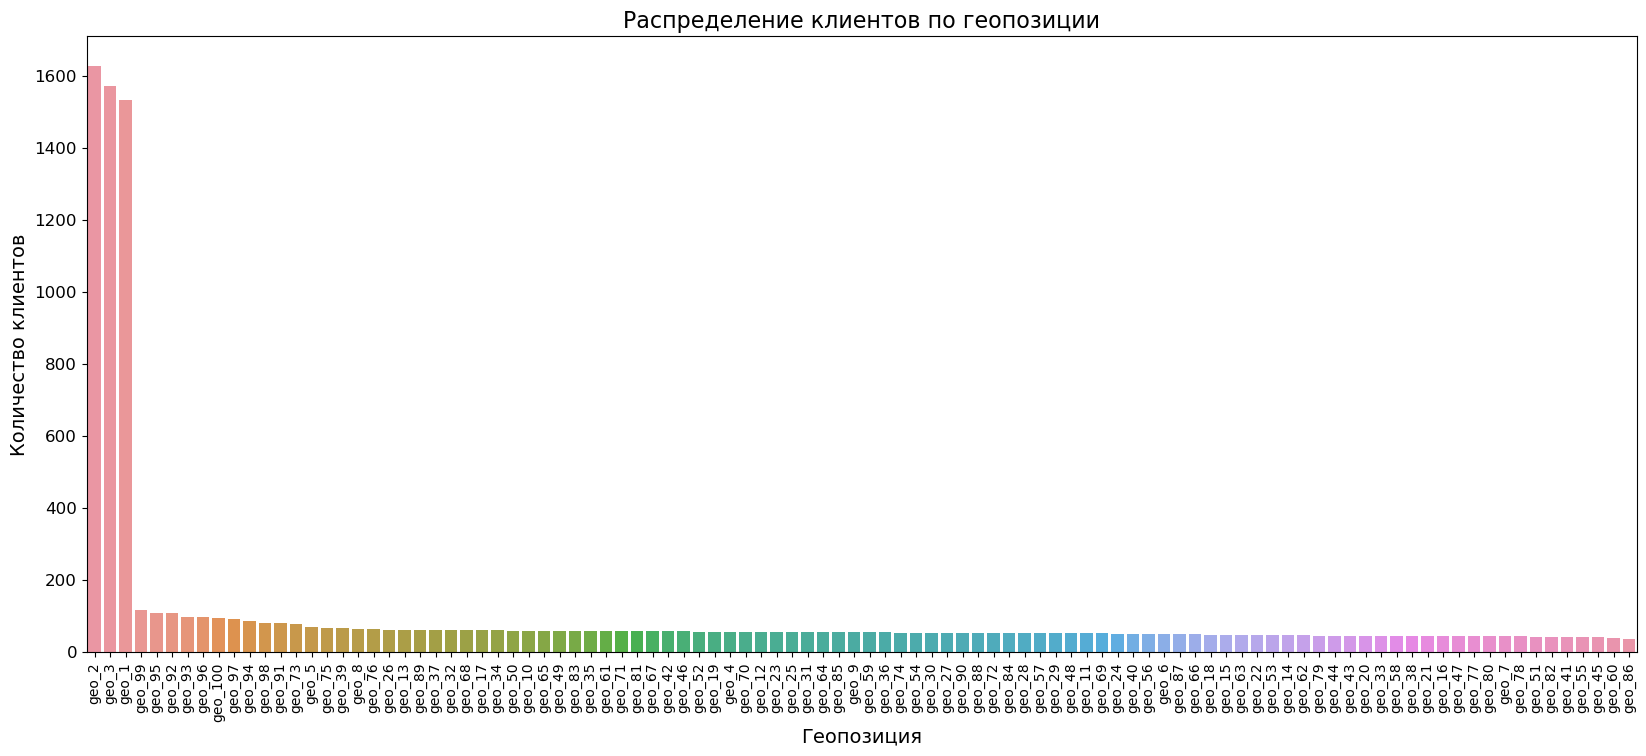

In [19]:
geo_df = start_df['geo_location'].value_counts().reset_index().sort_values(by='count', ascending=False)


plt.figure(figsize=(20, 8))
sns.barplot(data=geo_df, x='geo_location',
           y='count')

plt.xticks(rotation=90)
plt.yticks(fontsize=12)
plt.title('Распределение клиентов по геопозиции', fontsize=16)
plt.xlabel('Геопозиция', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.show()

Большая часть клиентов сосредоточена в 3 геолокациях - geo_2, geo_3, geo_1

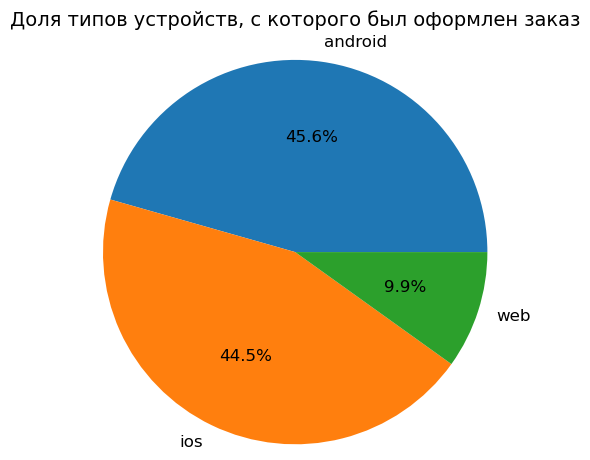

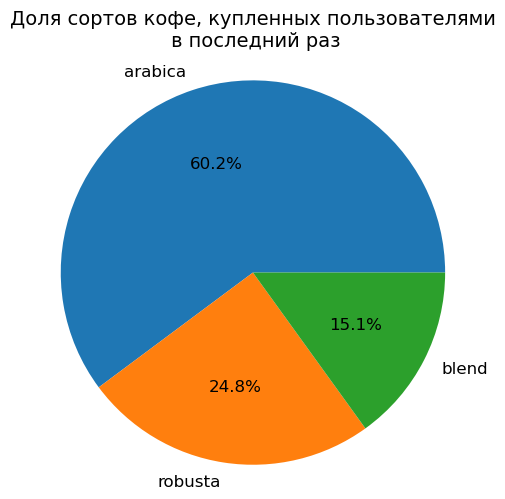

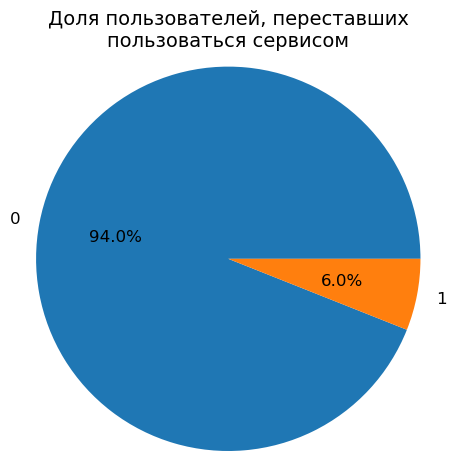

In [23]:
phone_type_df = start_df['phone_type'].value_counts().reset_index()

fig, ax = plt.subplots()
ax.pie(phone_type_df['count'],
       labels=phone_type_df['phone_type'],
       radius=1.3,
       autopct='%.1f%%',
       textprops=dict(color='black', fontsize=12))

ax.set_title('Доля типов устройств, с которого был оформлен заказ',
            fontsize=14, pad=30)
plt.show()


last_coffee_type_df = start_df['last_coffee_type'].value_counts().reset_index()
fig, ax = plt.subplots()
ax.pie(last_coffee_type_df['count'],
       labels=last_coffee_type_df['last_coffee_type'],
       radius=1.3,
       autopct='%.1f%%',
       textprops=dict(color='black', fontsize=12))

ax.set_title('Доля сортов кофе, купленных пользователями\n в последний раз',
            fontsize=14, pad=30)
plt.show()


churn_df = start_df['churn'].value_counts().reset_index()
fig, ax = plt.subplots()
ax.pie(churn_df['count'],
       labels=churn_df['churn'],
       radius=1.3,
       autopct='%.1f%%',
       textprops=dict(color='black', fontsize=12))

ax.set_title('Доля пользователей, переставших\nпользоваться сервисом',
            fontsize=14, pad=20)
plt.show()

  - Количество клиентов, пользующихся iphone и android примерно, одинаковое (44.5% и 45.6%), в то время как пользующихся web гораздно меньше - всего 9.9%
  - В последний раз большая часть пользователей (60.2%) покупали сорт arabica, robusta покупали 24.8% клиентов, и наименее популярным оказался blend : 15.1%
  - Распределение клиентов в целевом признаке - 'churn' несбалансировано, поскольку подавляющее большинство клиентов остаются (94%), а не уходят (6%)

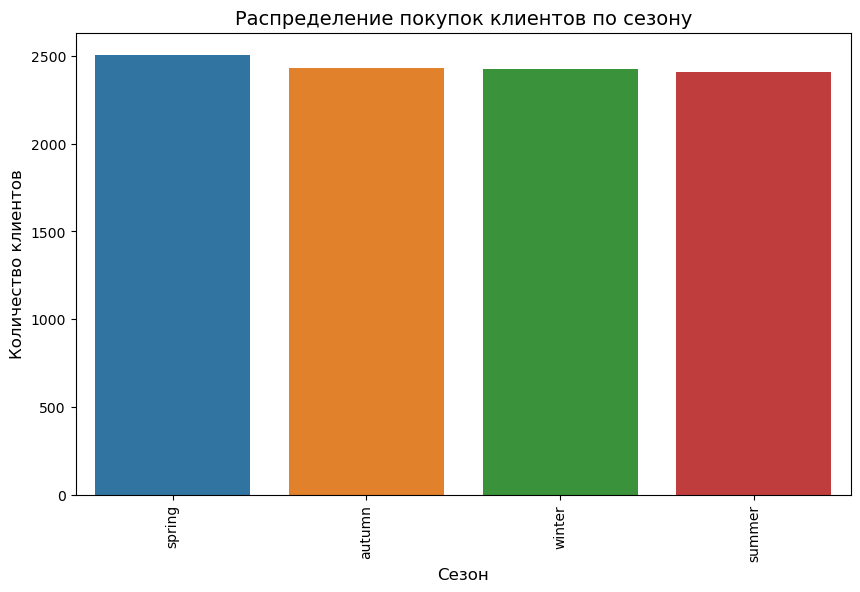

In [25]:
season_df = start_df['seasons'].value_counts().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=season_df, x='seasons',
           y='count')

plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Распределение покупок клиентов по сезону', fontsize=14)
plt.xlabel('Сезон', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.show()


Немного больше покупок клиенты совершают весной, но в целом сезон не оказывает существенного влияния на количество покупок.

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


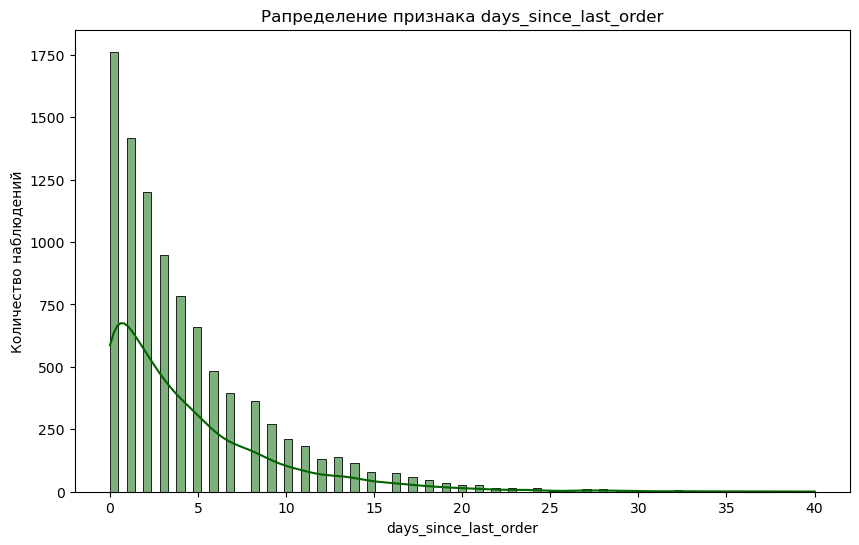

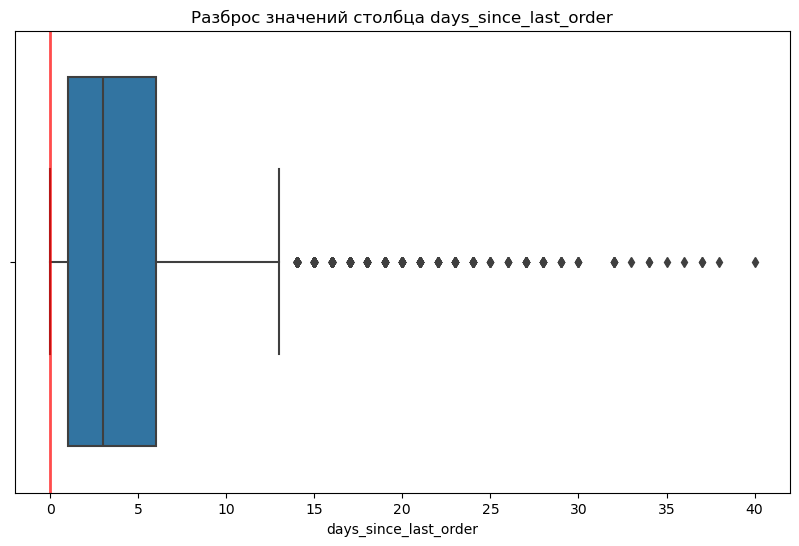

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


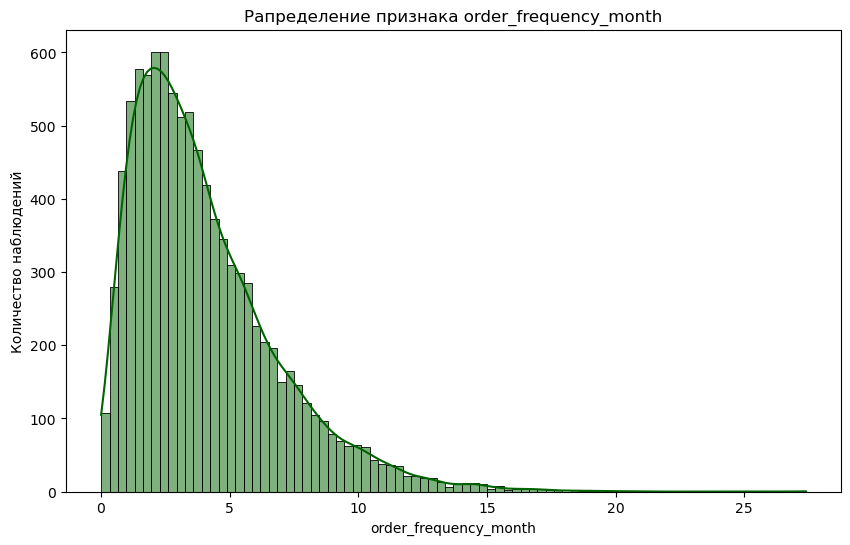

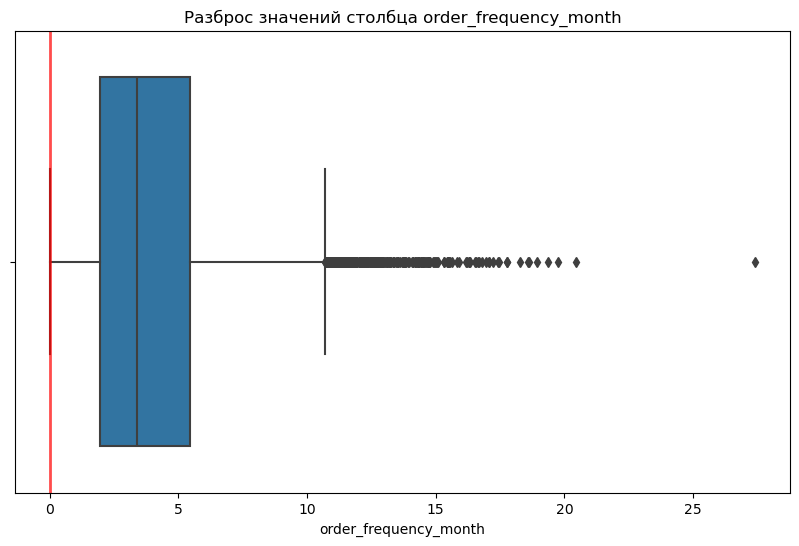

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


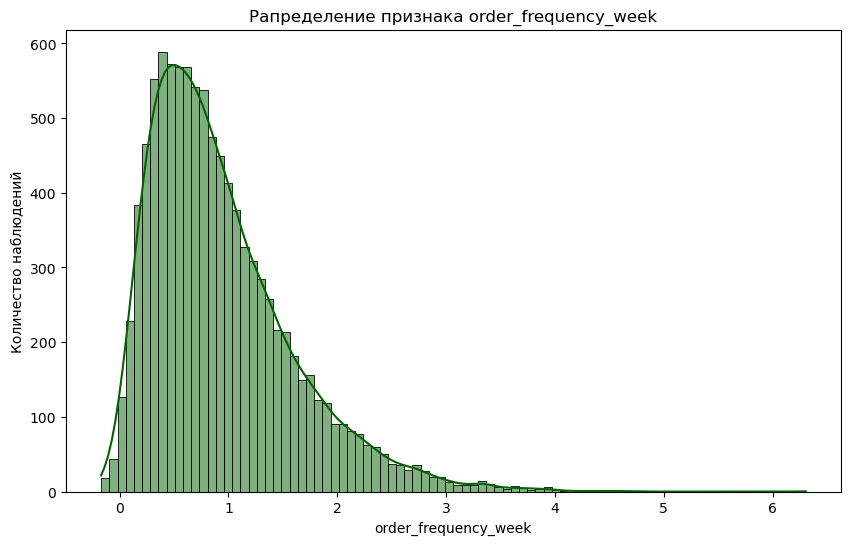

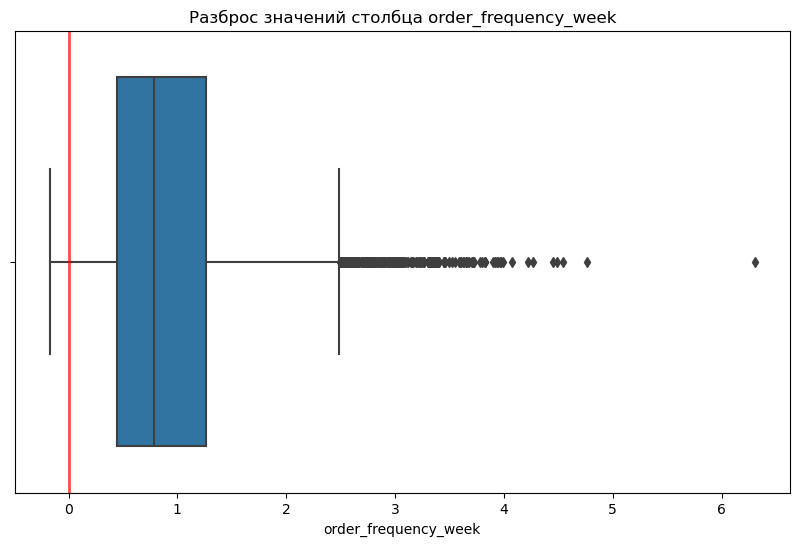

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


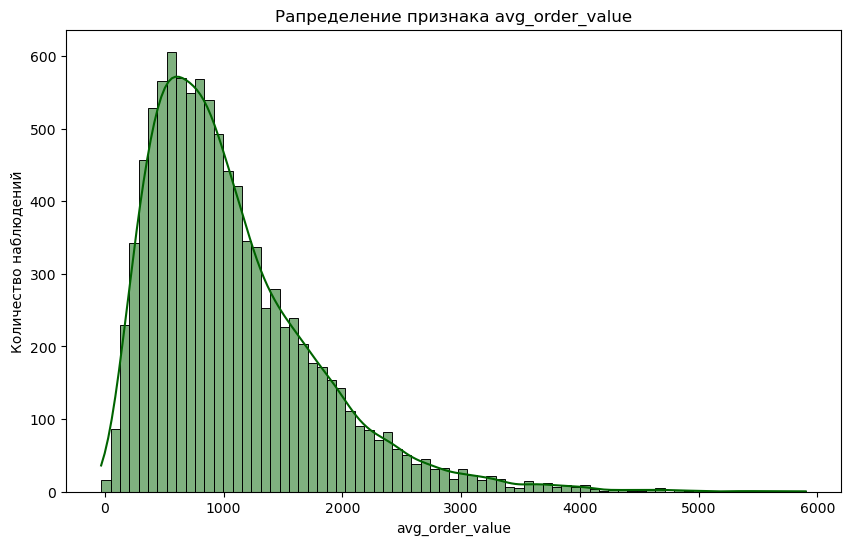

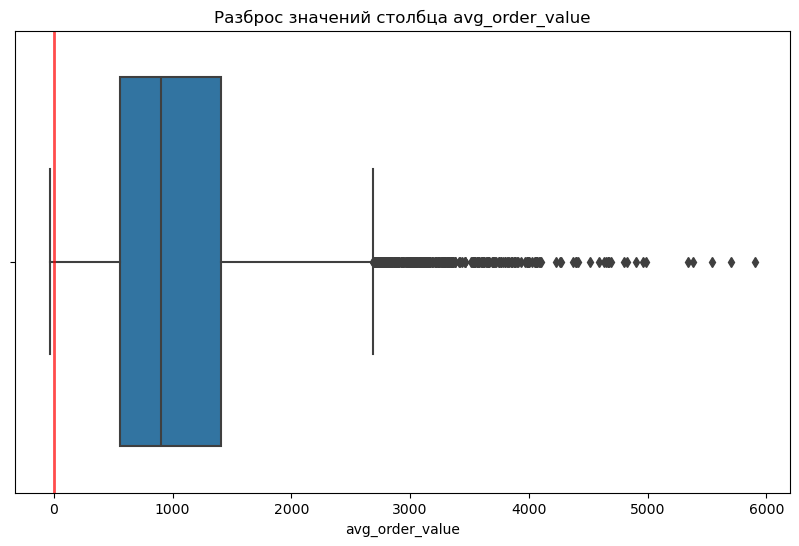

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


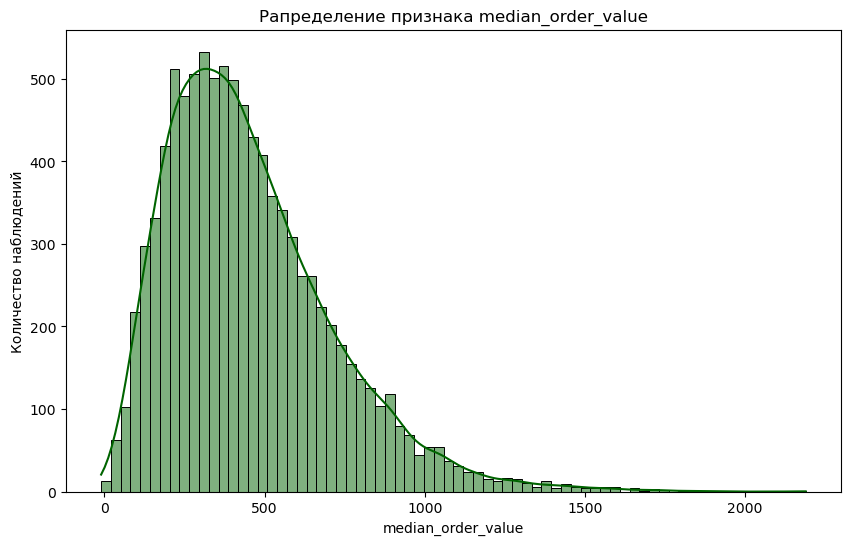

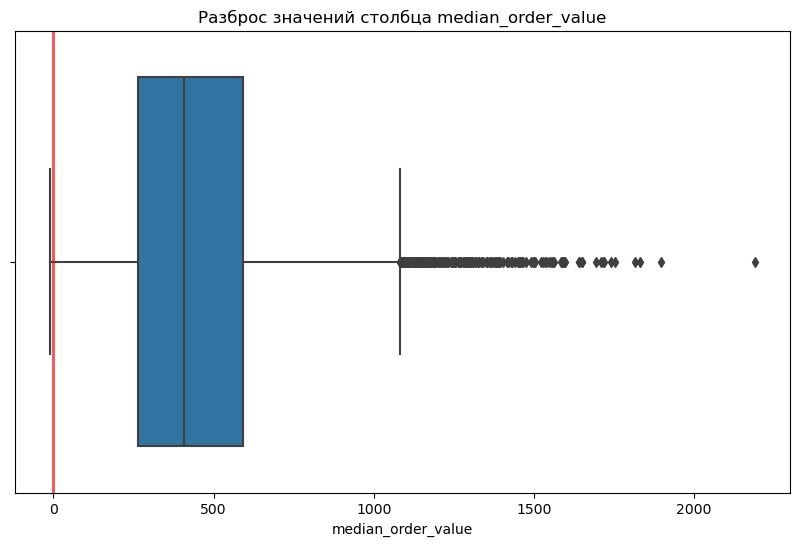

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


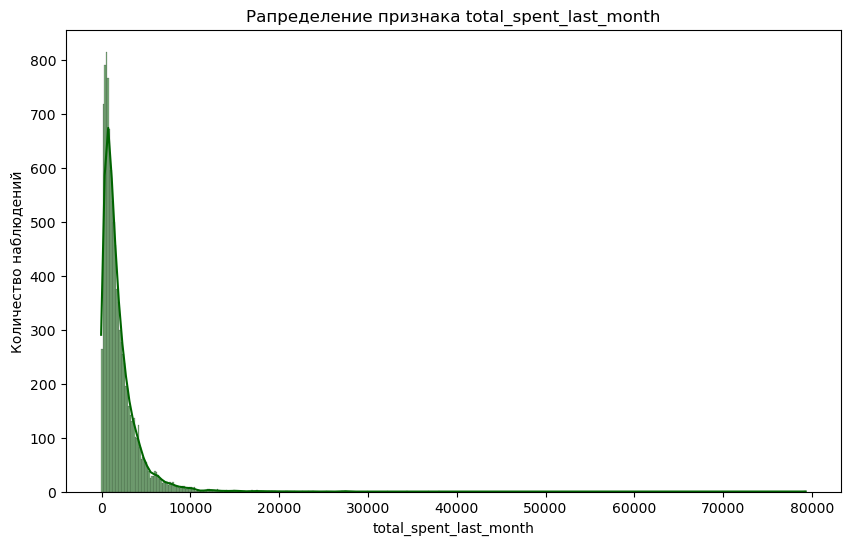

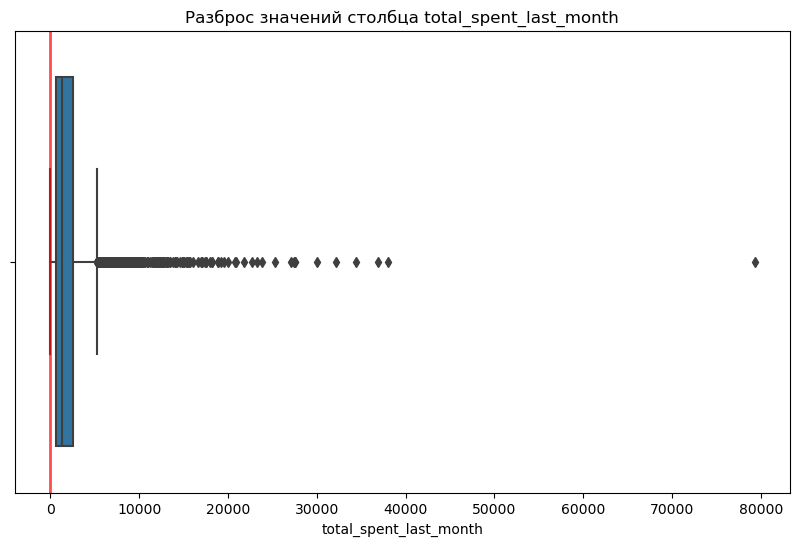

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


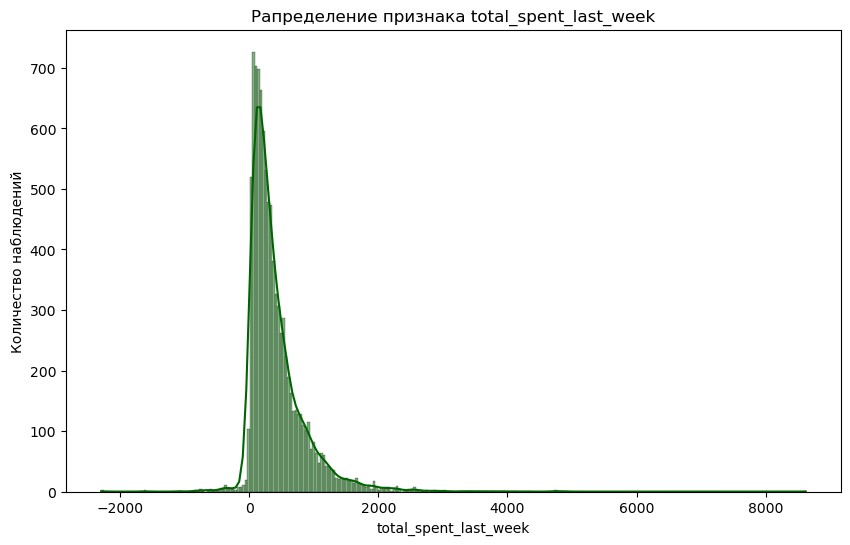

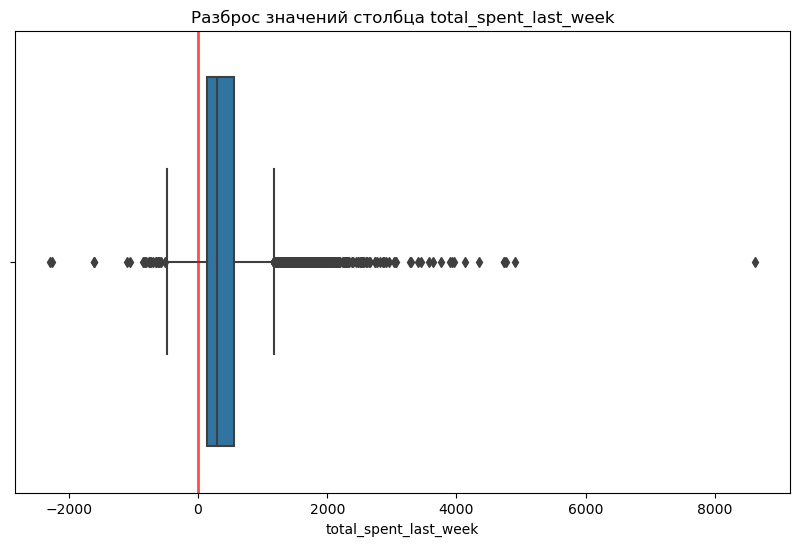

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


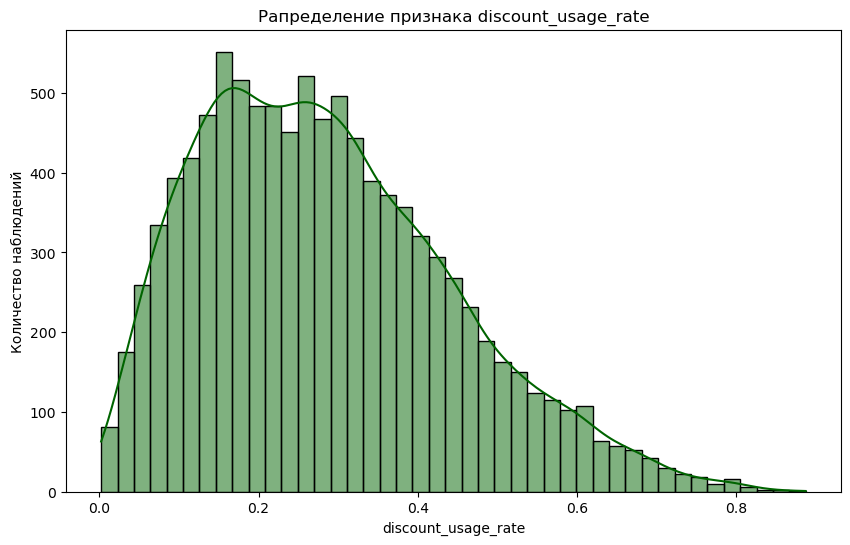

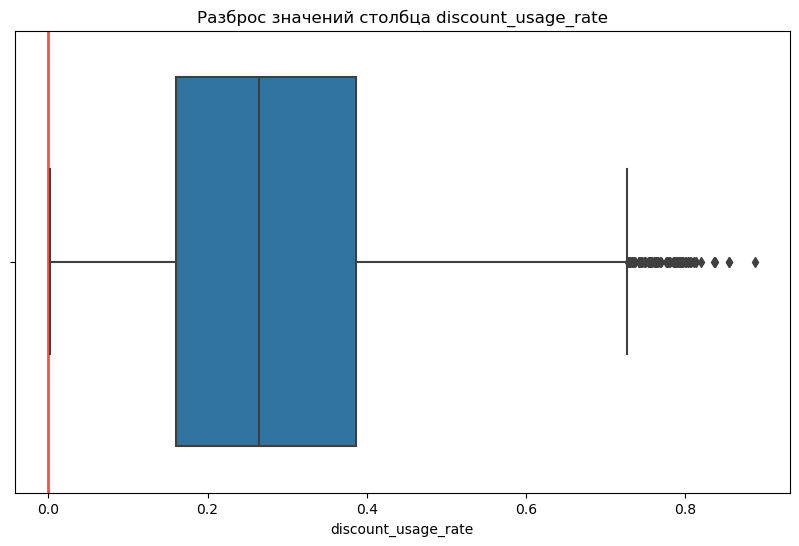

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


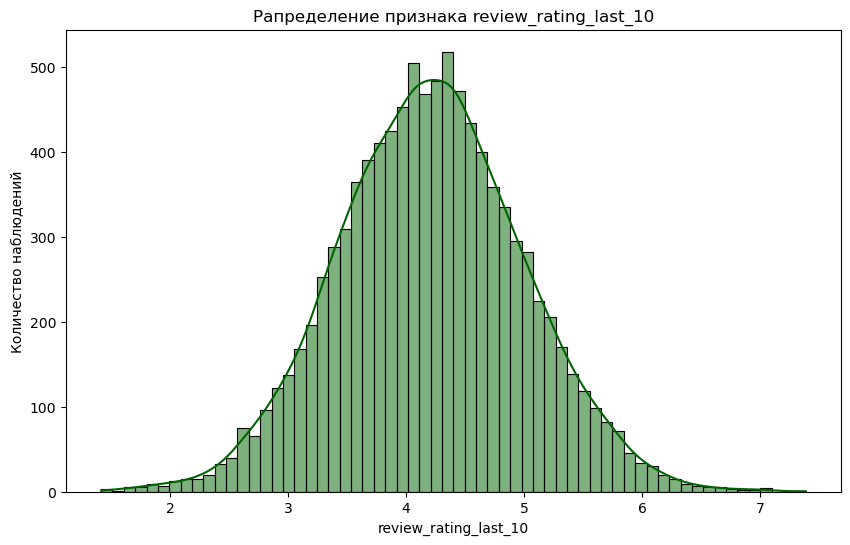

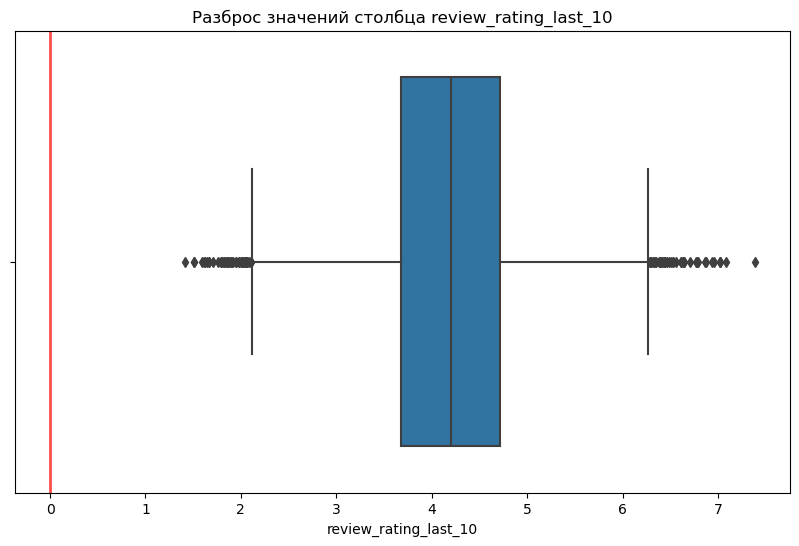

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


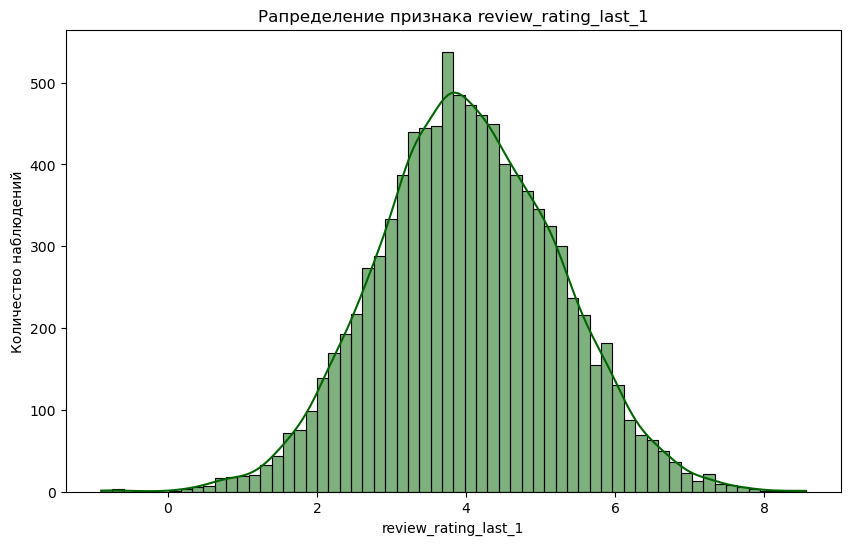

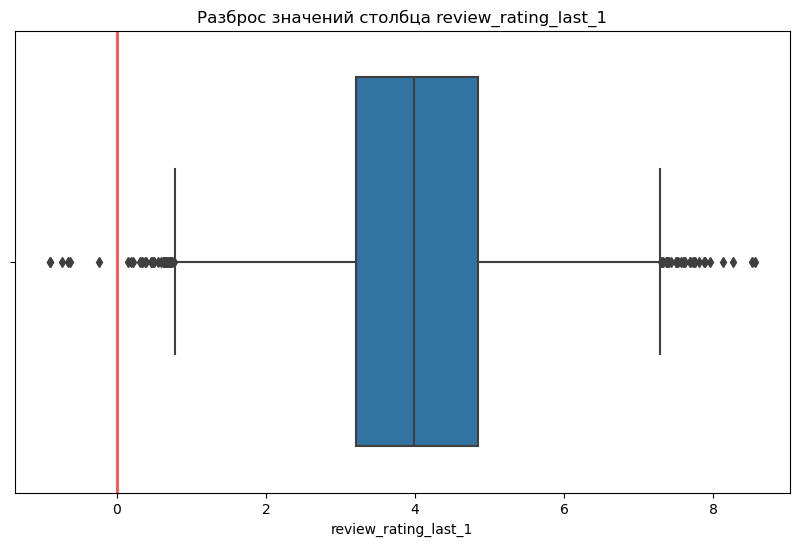

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


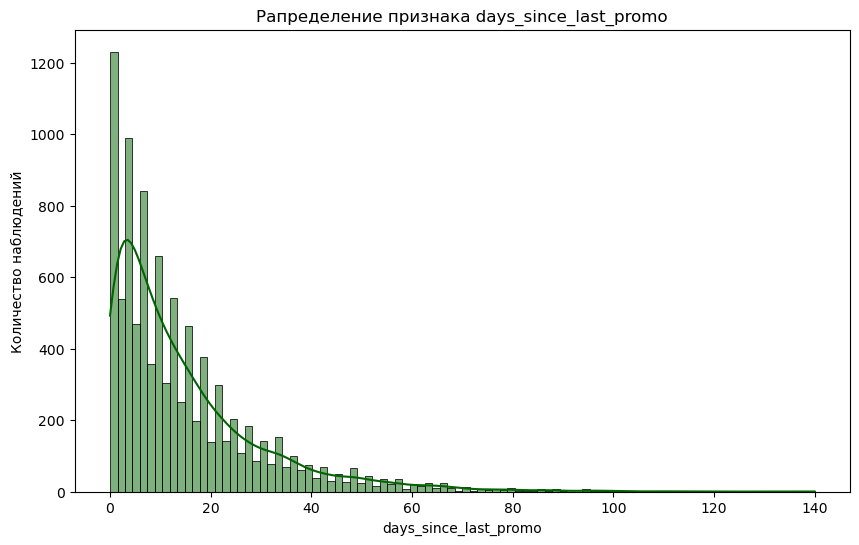

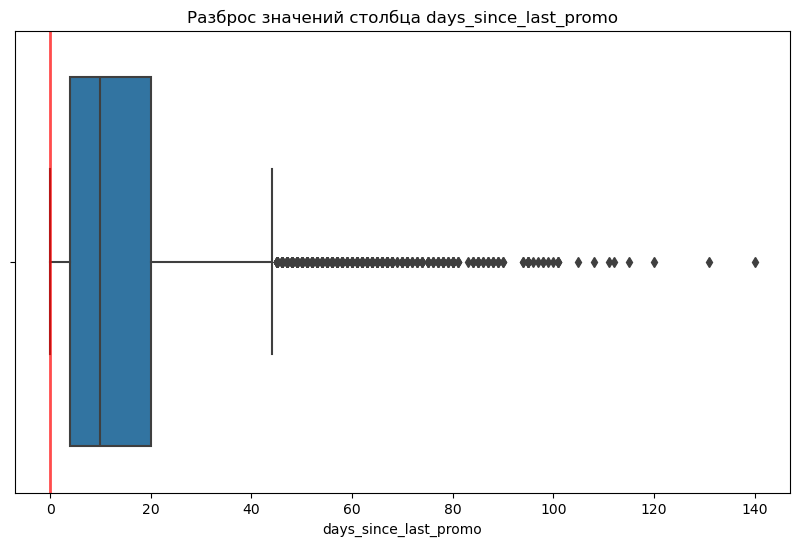

C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


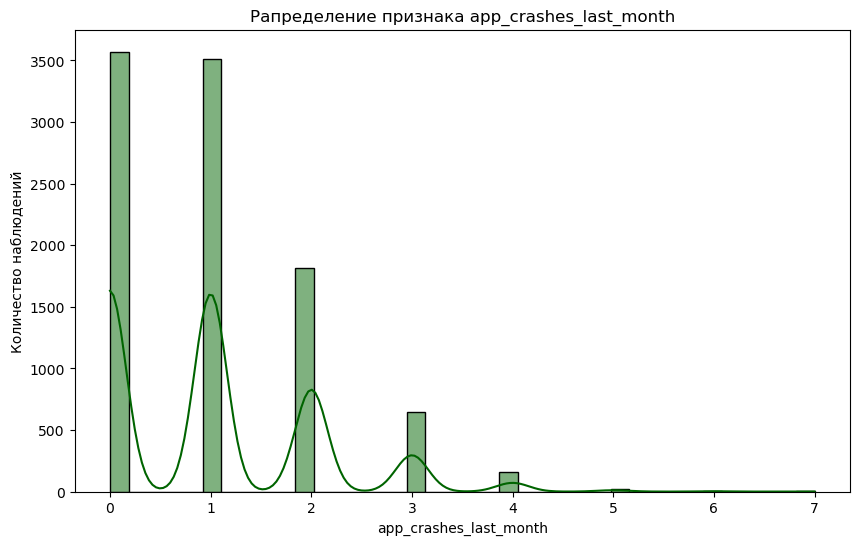

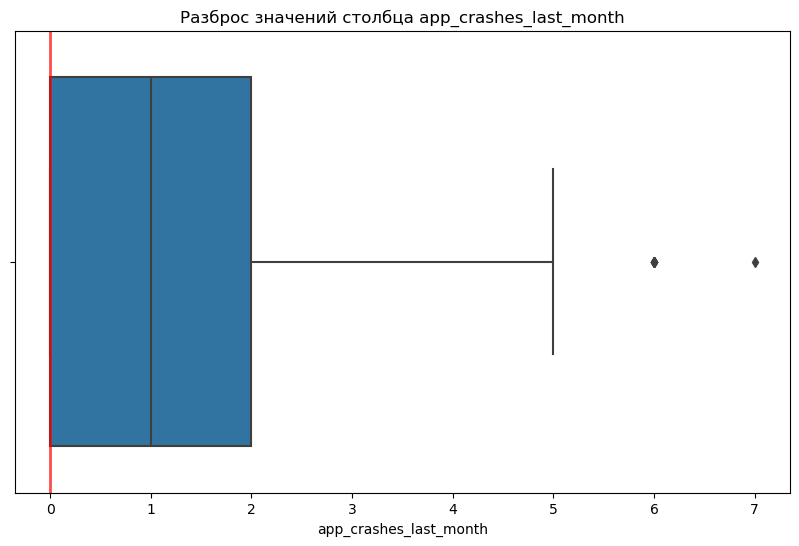

In [28]:
numeric_columns = ['days_since_last_order', 'order_frequency_month',
                  'order_frequency_week', 'avg_order_value',
                  'median_order_value', 'total_spent_last_month',
                  'total_spent_last_week', 'discount_usage_rate',
                  'review_rating_last_10', 'review_rating_last_1',
                  'days_since_last_promo', 'app_crashes_last_month']


for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=start_df, x=column, color='darkgreen', kde=True)
    plt.ylabel('Количество наблюдений')
    plt.title(f'Рапределение признака {column}')
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=start_df, x=column)
    plt.axvline(x=0, color='r', linestyle='-', linewidth=2, alpha=0.7)
    plt.title(f'Разброс значений столбца {column}')
    plt.show()

  - В столбцах order_frequency_week, avg_order_value, median_order_value, total_spent_last_week, review_rating_last_1, которые не должны быть отрицательны встречаются отрицательные значения, такие значения в дальнейшем можно заменить на медиану.
  - Во всех числовых небинарных столбцах существуют значения-выбросы, однако в признаках total_spent_last_week, total_spent_last_month и days_since_last_promo присутствуют аномальные значения, выделяющиеся даже среди выбросов
  - Все распредления кроме review_rating_last_1 и review_rating_last_10 имеют правостороннюю ассиметрию

interval columns not set, guessing: ['days_since_last_order', 'order_frequency_month', 'order_frequency_week', 'avg_order_value', 'median_order_value', 'total_spent_last_month', 'total_spent_last_week', 'discount_usage_rate', 'seasonal_menu_tried', 'app_opens_per_week', 'notifications_enabled', 'review_rating_last_10', 'review_rating_last_1', 'app_crashes_last_month', 'days_since_last_promo', 'coffee_preference_change', 'churn']


C:\Users\s-bek\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


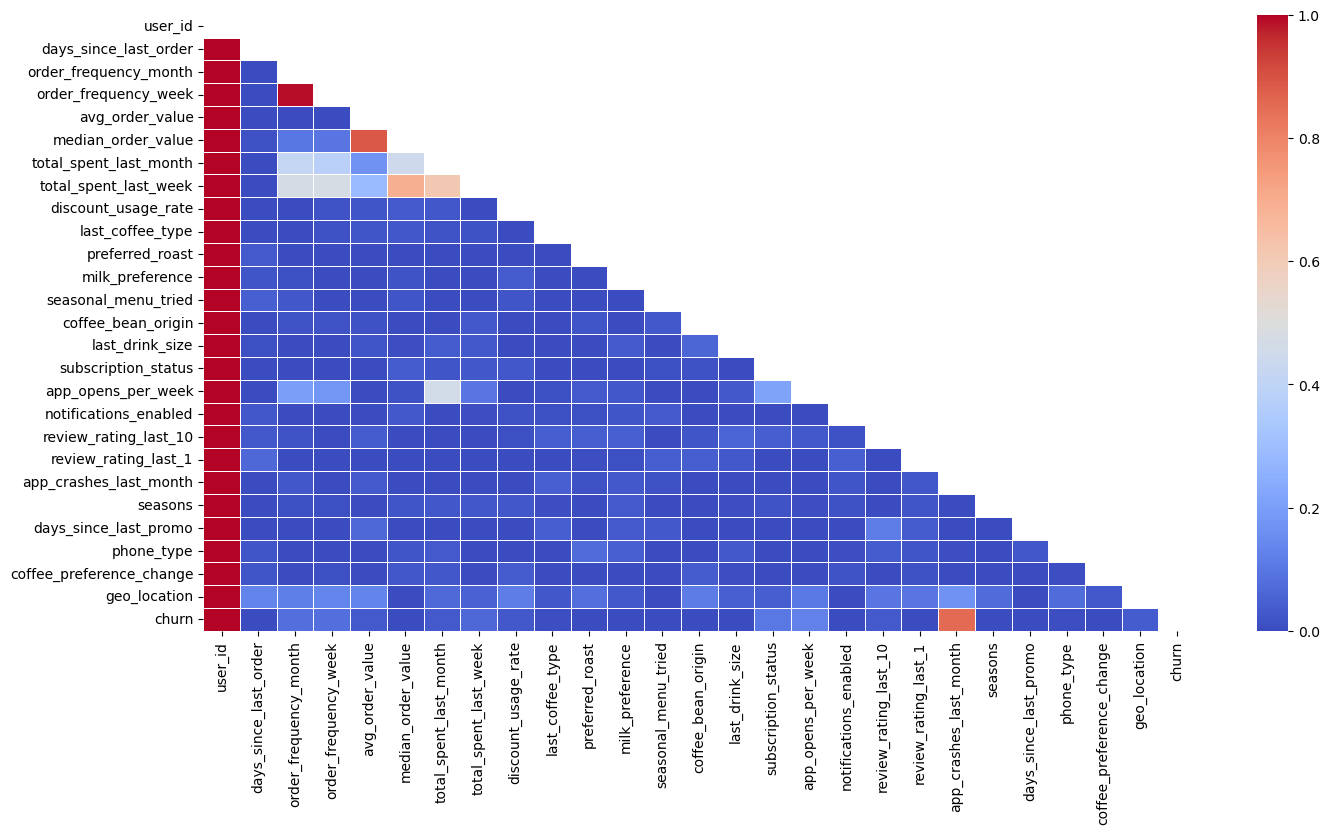

In [29]:
# Матрица корреляций
corr_data = start_df.phik_matrix()

plt.figure(figsize=(16, 8))
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(data=corr_data, annot=True,
            fmt='.2f', linewidths=0.5,
            cmap='coolwarm', mask=mask,)
plt.show()

Корреляция:
  - Сильная корреляция (0.85) с целевым признаком churn наблюдается у признака app_crashes_last_month
  - Очень сильная корреляция (0.99) наблюдается между признаками order_frequency_month и order_frequency_week
  - Сильная коррелция (0.89) между avg_order_value, median_order_value
  - Сильная корреляция (0.7) между total_spent_last_week и median_order_value
  - Средняя коррецлия (0.61) между total_spent_last_week и total_spent_last_month
  - Средняя корреляция (0.46) между total_spent_last_month и app_opens_per_week
  - Средняя корреляция (0.41) между total_spent_last_month и offer_frequency_month
  - Средняя корреляция (0.47) между total_spent_last_week и offer_frequency_month

Лишние признаки:
  - last_coffee_type: ни с чем не коррелирует и вряд ли может оказывать влияние на целевую переменную
  - preferred_roast: ни с чем не коррелирует и вряд ли может оказывать влияние на целевую переменную
  - milk_preference: ни с чем не коррелирует и вряд ли может оказывать влияние на целевую переменную
  - seasonal_menu_tried: ни с чем не коррелирует и вряд ли может оказывать влияние на целевую переменную
  - coffee_bean_origin: ни с чем не коррелирует и вряд ли может оказывать влияние на целевую переменную
  - last_drink_size: ни с чем не коррелирует и вряд ли может оказывать влияние на целевую переменную
  - order_frequency_week: 0.99 корреляция с order_frequency_month, но в order_frequency_month нет отрицательных значений, поэтому имеет смысл оставить только order_frequency_month
  - avg_order_value: сильная коррелция с median_order_value, но в median_order_value нет отрицательных значений, поэтому имеет смысл оставить только median_order_value
  - notifications_enabled: ни с чем не коррелирует и вряд ли может оказывать влияние на целевую переменную
  - days_since_last_promo: ни с чем не коррелирует и вряд ли может оказывать влияние на целевую переменную

In [30]:
col_for_del = ['user_id', 'last_coffee_type', 'preferred_roast',
              'milk_preference', 'seasonal_menu_tried',
              'coffee_bean_origin', 'last_drink_size',
              'order_frequency_week', 'avg_order_value',
              'notifications_enabled',
              'days_since_last_promo']
df_cleaned = start_df.drop(columns=col_for_del)

In [31]:
df_cleaned.head()

,days_since_last_order,order_frequency_month,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,subscription_status,app_opens_per_week,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,phone_type,coffee_preference_change,geo_location,churn
0,0.0,12.942519,260.645090,3089.991009,NaN,0.337031,pro,30.468321,5.176792,3.302238,NaN,summer,android,0.0,geo_75,1
1,2.0,1.569146,540.597850,998.380941,107.369409,0.547659,none,NaN,4.392991,NaN,0.0,autumn,ios,0.0,geo_95,0
2,11.0,2.996666,471.494559,1328.140204,392.600011,0.120258,premium,17.895637,4.977712,4.379219,0.0,spring,web,1.0,geo_25,0
3,0.0,4.299255,708.529812,2999.628366,1084.352054,NaN,none,11.405533,3.712526,3.043618,0.0,summer,android,0.0,geo_2,0
4,3.0,7.249864,1199.372894,8377.729478,2551.775211,0.074990,none,15.948239,4.528271,5.642993,1.0,winter,ios,0.0,geo_19,1


В оставшемся датафрейме есть категориальные признаки которые можно кодировать:
  - 'subscription_status', 'seasons' и 'phone_type' представлены малым числом уникальных значений и могут быть кодированы с помощью OneHotEncoder
  - признак 'geo_location' представлен большим количеством уникальных значений и будт кодирован с помощью TargetEncoder

## Этап 3. Предобработка данных

1. Разделите данные в пропорции 80 к 20. 20% данных отложите для теста. Остальные используйте для обучения и кросс-валидации модели.

2. Предобработайте данные. Используйте информацию о пропусках и категориальных признаках только из обучающей выборки.

   - Создайте пайплайн, который обработает пропуски и выбросы.

   - Создайте пайплайн, который обработает категориальные признаки.

   - Создайте пайплайн, который обработает числовые признаки: проведёт масштабирование и нормализацию.



In [32]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   days_since_last_order     9505 non-null   float64
 1   order_frequency_month     9850 non-null   float64
 2   median_order_value        9619 non-null   float64
 3   total_spent_last_month    10156 non-null  float64
 4   total_spent_last_week     9506 non-null   float64
 5   discount_usage_rate       10053 non-null  float64
 6   subscription_status       9512 non-null   object 
 7   app_opens_per_week        9554 non-null   float64
 8   review_rating_last_10     9757 non-null   float64
 9   review_rating_last_1      9593 non-null   float64
 10  app_crashes_last_month    9729 non-null   float64
 11  seasons                   9771 non-null   object 
 12  phone_type                10114 non-null  object 
 13  coffee_preference_change  9840 non-null   float64
 14  geo_lo

In [33]:
numerical_features = ['days_since_last_order', 'order_frequency_month',
                     'median_order_value', 'total_spent_last_month',
                     'discount_usage_rate', 'app_opens_per_week',
                     'review_rating_last_10', 'review_rating_last_1',
                     'app_crashes_last_month', 'coffee_preference_change', 'total_spent_last_week']
categorial_features_one_hot = ['subscription_status', 'seasons', 'phone_type']
categorial_features_target_enc = ['geo_location']

In [34]:
# В столбцах, где по логике не может быть отрицательных значений, заменяем их на nan
for feature in numerical_features:
    df_cleaned[feature] = df_cleaned[feature].where(df_cleaned[feature] >= 0, np.nan)

In [35]:
X = df_cleaned.drop(columns='churn')
y = df_cleaned['churn']

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,
                                                  stratify=y, shuffle=True,
                                                  random_state=RANDOM_STATE)

In [36]:
def preproces(categorial_features_one_hot, categorial_features_target_enc, numerical_features):
    

    categorial_onehot_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    categorial_target_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('target', TargetEncoder())
    ])

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat_1', categorial_onehot_transformer, categorial_features_one_hot),
            ('cat_2', categorial_target_transformer, categorial_features_target_enc),
            ('num', numeric_transformer, numerical_features)
    ])
    
    return preprocessor

In [37]:
preprocessor = preproces(categorial_features_one_hot=categorial_features_one_hot,
                        categorial_features_target_enc=categorial_features_target_enc,
                        numerical_features=numerical_features)

transformed_features = preprocessor.fit_transform(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()

df_transformed = pd.DataFrame(transformed_features, columns=feature_names)
df_transformed

,cat_1__subscription_status_basic,cat_1__subscription_status_missing,cat_1__subscription_status_none,cat_1__subscription_status_premium,cat_1__subscription_status_pro,cat_1__seasons_autumn,cat_1__seasons_missing,cat_1__seasons_spring,cat_1__seasons_summer,cat_1__seasons_winter,...,num__order_frequency_month,num__median_order_value,num__total_spent_last_month,num__discount_usage_rate,num__app_opens_per_week,num__review_rating_last_10,num__review_rating_last_1,num__app_crashes_last_month,num__coffee_preference_change,num__total_spent_last_week
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.628192,-1.132496,-0.479802,0.306474,0.417651,0.005103,0.225208,-1.035851,2.134202,-0.466994
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.322973,0.132280,-0.145133,-0.753629,-0.317535,-0.190065,-1.079130,-1.035851,-0.468559,-0.187207
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.003224,-0.124142,-0.151629,-1.379364,-0.139264,-0.503429,1.652508,-1.035851,2.134202,0.168820
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.277758,1.922805,0.464558,-0.171517,-0.139264,0.050845,-2.037589,-1.035851,-0.468559,1.229554
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.493378,-0.740851,-0.537912,-0.054128,-0.001142,-1.379354,0.825838,-0.007381,-0.468559,-0.279266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8355,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.647193,-0.827518,0.067006,0.312795,-0.145699,-0.306741,-0.833639,-0.007381,-0.468559,0.373494
8356,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.866921,0.048713,-0.489715,-0.775383,-0.059467,0.498263,-0.635247,-1.035851,-0.468559,-0.428238
8357,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.032449,-0.737753,-0.333950,2.117167,-0.301691,0.413236,0.506953,-1.035851,-0.468559,-0.422573
8358,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.367848,2.675288,2.689431,-0.807860,-0.067173,0.067777,-0.802038,-1.035851,-0.468559,-0.279266


## Этап 4. Обучение модели

1. Обучите базовую версию модели.
   - Используйте для этого простые статистические модели.

   - Используйте кросс-валидацию для обучения модели.

2. Посчитайте метрики, поставленные в задаче. Опираясь на них, сделайте вывод о качестве модели.

In [38]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

dummy_pipline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE))
])

In [40]:
def evaluate_model_cv(model, X, y, N_FOLDS = 5):
    kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    scoring = {
        'precision' : make_scorer(precision_score, zero_division=0),
        'recall' : 'recall',
        'f1' : 'f1',
        'log_loss': 'neg_log_loss',
        'average_precision': 'average_precision',
        'roc_auc': 'roc_auc'
    }

    cv_results = cross_validate(
        model,
        X,
        y,
        cv=kfold,
        scoring=scoring,
        return_train_score=False
    )

    print(f"Результаты модели {model['classifier']}:")
    print(f"CV Precision: {cv_results['test_precision'].mean():.4f}")
    print(f"CV Recall: {cv_results['test_recall'].mean():.4f}")
    print(f"CV F1: {cv_results['test_f1'].mean():.4f}")
    print(f"CV LogLoss: {-cv_results['test_log_loss'].mean():.4f}")
    print(f"CV PR-AUC: {cv_results['test_average_precision'].mean():.4f}")
    print(f"CV ROC-AUC: {cv_results['test_roc_auc'].mean():.4f}")
    
    y_scores = cross_val_predict(model, X, y, cv=kfold, 
                                     method='predict_proba')[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y, y_scores)
    avg_precision = cv_results['test_average_precision'].mean()
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR-кривая (AUC = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall кривая')
    plt.legend()
    plt.show()
    
    # return y_scores

Результаты модели LogisticRegression(random_state=42):
CV Precision: 0.7898
CV Recall: 0.4434
CV F1: 0.5647
CV LogLoss: 0.1211
CV PR-AUC: 0.6771
CV ROC-AUC: 0.9255


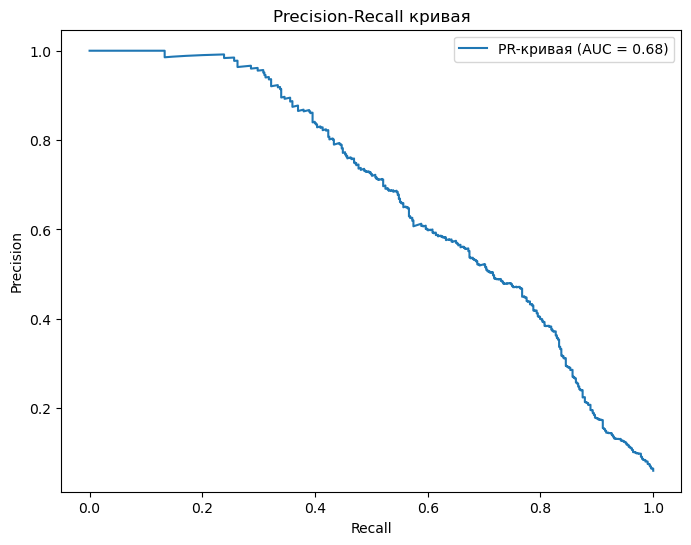


Результаты модели DummyClassifier(random_state=42, strategy='most_frequent'):
CV Precision: 0.0000
CV Recall: 0.0000
CV F1: 0.0000
CV LogLoss: 2.1687
CV PR-AUC: 0.0602
CV ROC-AUC: 0.5000


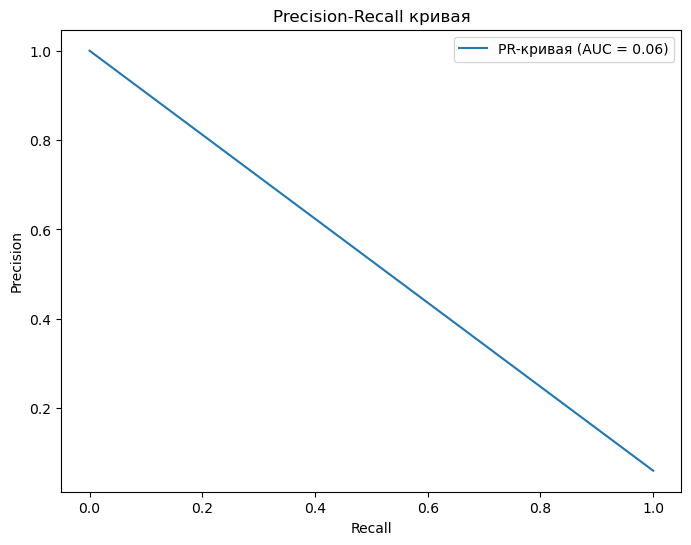

In [41]:
evaluate_model_cv(model=full_pipeline, X=X_train, y=y_train)
print()
evaluate_model_cv(model=dummy_pipline, X=X_train, y=y_train)

  - Из-за сильного дисбаланса в данных получилась довольно точная, но очень осторожная модель, которая плохо выявляет позитивные случаи
  - Модель верно предсказывает позитивные случае в ~80% случаев
  - Из всех реальных позитивных случаев в данных модель находит и правильно определяет только ~45%
  - F1 = ~0.57 указывает на проблему с низкой полнотой
  - Значение log_loss = 0.1211 является хорошим результатом
  - PR-AUC: 0.6769 являтся неплохим результатом (модель в ~11 раз превосходит случайную)
  - ROC-AUC: 0.9254 отличный результат

## Этап 5. Создание новых признаков

1. Добавьте новые признаки, которые могут улучшить качество модели. Опирайтесь на наработки, полученные в ходе исследовательского анализа данных, и на логику решаемой задачи.

   - Извлечение квадратного корня поможет сгладить большие значения.

   - Возведение в квадрат усилит влияние больших значений.

2. Обновите пайплайн для работы с новыми признаками, проведите повторную кросс-валидацию, сравните результаты моделей с новыми признаками и без них.

3. Интерпретируйте коэффициенты модели, а затем на их основании выявите значимые признаки и удалите лишние для модели.

In [42]:
def create_enhanced_features(X):
     
    X_enhanced = X.copy()
    
    # Логарифмирование
    try:
        X_enhanced['log_total_spent_last_month'] = np.log1p(X['total_spent_last_month'])
    except:
        print('Не найден столбец total_spent_last_month')
    
    try:
        X_enhanced['log_app_opens_per_week'] = np.log1p(X['app_opens_per_week'])
    except:
        print('Не найден столбец app_opens_per_week')
        
    try:
        X_enhanced['log_total_spent_last_week'] = np.log1p(X['total_spent_last_week'])
    except:
        print('Не найден столбец total_spent_last_week')
              
    # Извлечение квадратного корня
    try:
        X_enhanced['sqrt_days_since_last_order'] = np.sqrt(X['days_since_last_order'])
    except:
        print('Не найден столбец days_since_last_order')
    
    try:
        X_enhanced['sqrt_order_frequency_month'] = np.sqrt(X['order_frequency_month'])
    except:
        print('Не найден столбец order_frequency_month')
    
    try:
        X_enhanced['sqrt_median_order_value'] = np.sqrt(X['median_order_value'])
    except:
        print('Не найден столбец median_order_value')
    
    # Добавляем новые признаки
    try:
        X_enhanced['stability_coef'] = X['app_opens_per_week'] / (X['app_crashes_last_month'] + 1)
    except:
        print('Признак stability_coef не добавлен')
    
    columns_to_drop = [
    'total_spent_last_month',
    'app_opens_per_week',
    'days_since_last_order',
    'order_frequency_month',
    'median_order_value',
    'total_spent_last_week'
    ]

    # Удаляем указанные колонки
    X_enhanced = X_enhanced.drop(columns=columns_to_drop)

    return X_enhanced

In [43]:
X_train_enhanced = create_enhanced_features(X_train)

numerical_features = ['discount_usage_rate', 'review_rating_last_10',
                     'review_rating_last_1', 'app_crashes_last_month',
                     'log_total_spent_last_month', 'log_app_opens_per_week',
                     'sqrt_days_since_last_order', 'sqrt_order_frequency_month',
                     'sqrt_median_order_value', 'coffee_preference_change',
                      'stability_coef', 'log_total_spent_last_week']
categorial_features_one_hot = ['subscription_status', 'seasons', 'phone_type']
categorial_features_target_enc = ['geo_location']

preprocessor = preproces(categorial_features_one_hot=categorial_features_one_hot,
                         categorial_features_target_enc=categorial_features_target_enc,
                         numerical_features=numerical_features)

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

Коэффициенты признаков:
discount_usage_rate : -0.30
subscription_status : -0.07
review_rating_last_10 : -0.22
review_rating_last_1 : -0.05
app_crashes_last_month : 0.56
seasons : -0.19
phone_type : 0.43
coffee_preference_change : -0.15
geo_location : -0.06
log_total_spent_last_month : -0.12
log_app_opens_per_week : 0.27
log_total_spent_last_week : 0.02
sqrt_days_since_last_order : -0.15
sqrt_order_frequency_month : -0.23
sqrt_median_order_value : 0.52
stability_coef : -0.01
Свободный коэффициент: -4.91




C:\Users\s-bek\AppData\Local\Temp\ipykernel_16168\3678523080.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Свободный коэффициент: {float(intercept):.2f}\n")


Результаты модели LogisticRegression(random_state=42):
CV Precision: 0.7895
CV Recall: 0.4891
CV F1: 0.6008
CV LogLoss: 0.1166
CV PR-AUC: 0.6980
CV ROC-AUC: 0.9315


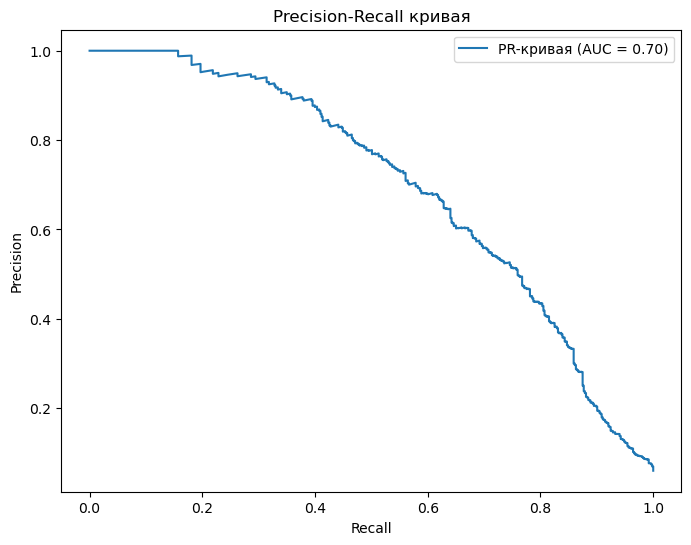

In [44]:
full_pipeline.fit(X_train_enhanced, y_train)

model = full_pipeline.named_steps['classifier']
coeffs = model.coef_
intercept = model.intercept_

print('Коэффициенты признаков:')
for i in range(len(X_train_enhanced.columns)):
    print(f"{X_train_enhanced.columns[i]} : {coeffs[0][i]:.2f}")
print(f"Свободный коэффициент: {float(intercept):.2f}\n")

print()
evaluate_model_cv(model=full_pipeline, X=X_train_enhanced, y=y_train)

Добавление и модернизация признаков слегка улучшило модель:
  - CV Precision: 0.7923 -> 0.7890
  - CV Recall: 0.4434 -> 0.4871
  - CV F1: 0.5654 -> 0.5993
  - CV LogLoss: 0.1211 -> 0.1166
  - CV PR-AUC: 0.6771 -> 0.6983
  - CV ROC-AUC: 0.9254 -> 0.9314
  
Выводы по коэффициентам модели:
  - наибольшее значение имеет признак app_crashes_last_month : 0.57 - чем больше приложение зависает - тем больше клиенты склонны к тому чтобы перестать пользоваться сервисом
  - признак phone_type : 0.45, скорее всего это также связано с большим зависанием приложения на определенных типах устройства
  - признак log_app_opens_per_week : 0.29 также возможно связно с зависанием приложения, из-за чего клиентам приходится перезапускать приложение
  - признак discount_usage_rate : -0.28 - клиенты, пользующиеся скидками являются более лояльными
  - признак review_rating_last_10 : -0.20 - очевидно, что клиенты оставляющие лучший рейтинг менее склонны прекращать пользоваться сервисом
  
Лишние для модели признаки на основе коэффициентов:
  - stability_coef : -0.01
  - log_total_spent_last_week : 0.04
  - geo_location : -0.04

Результаты модели LogisticRegression(random_state=42):
CV Precision: 0.7919
CV Recall: 0.4811
CV F1: 0.5958
CV LogLoss: 0.1168
CV PR-AUC: 0.6942
CV ROC-AUC: 0.9311


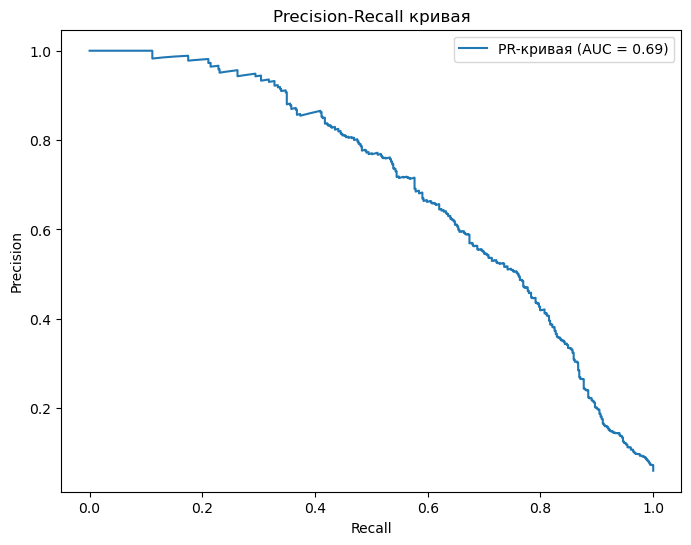

In [45]:
X_train_enhanced_cleaned = X_train_enhanced.drop(columns=['stability_coef', 'log_total_spent_last_week', 'geo_location'])

numerical_features = ['discount_usage_rate', 'review_rating_last_10',
                     'app_crashes_last_month',
                     'log_total_spent_last_month', 'log_app_opens_per_week',
                     'sqrt_order_frequency_month',
                     'sqrt_median_order_value', 'coffee_preference_change',
                     'sqrt_days_since_last_order', 'review_rating_last_1']
categorial_features_one_hot = ['subscription_status', 'seasons', 'phone_type']
categorial_features_target_enc = [] #'geo_location'

preprocessor = preproces(categorial_features_one_hot=categorial_features_one_hot,
                         categorial_features_target_enc=categorial_features_target_enc,
                         numerical_features=numerical_features)

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

evaluate_model_cv(model=full_pipeline, X=X_train_enhanced_cleaned, y=y_train)

## Этап 6. Эксперименты с гиперпараметрами

1. Перечислите все гиперпараметры, с которыми планируете экспериментировать.

2. Проведите систематический перебор гиперпараметров для `LogisticRegression`, выполните кросс-валидацию для каждой конфигурации.

3. Составьте таблицу с результатами.

4. Выберите лучшую модель, ориентируясь на заданную метрику качества.

Гиперпараметры для экспериментов:
  - сила регуляризации (classifier__C)
  - алгоритм оптимизации (classifier__solver)
  - веса классов (classifier__class_weight)
  - тип регуляризации (classifier__penalty)
  - пропорция L1/L2 для elasticnet (classifier__l1_ratio)

In [ ]:
param_grid = [
    {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'liblinear'],
        'classifier__class_weight': ['balanced', None]
    },
    {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['saga'],
        'classifier__penalty': ['l1', 'l2', 'elasticnet'],
        'classifier__l1_ratio': [0.2, 0.5, 0.8],
        'classifier__class_weight': ['balanced', None]
    }
]

def optimize_model_grid(model, X, y, param_grid):

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    search = GridSearchCV(
        model,
        param_grid,
        cv=kfold,
        scoring='average_precision',
        n_jobs=-1,
        verbose=1,
        refit=True,
        return_train_score=True
    )
    
    search.fit(X, y)
    
    results_df = pd.DataFrame(search.cv_results_)
    
    results_df = results_df.sort_values('rank_test_score')
    
    display_cols = ['rank_test_score', 'mean_test_score', 'std_test_score', 
                    'param_classifier__C', 'param_classifier__solver',
                    'param_classifier__class_weight', 'param_classifier__penalty']
    
    display_cols = [col for col in display_cols if col in results_df.columns]
    
    summary = results_df[display_cols].head(20).copy()
    
    return search.best_estimator_, search.best_params_, summary


best_model, best_params, results_table = optimize_model_grid(
    model=full_pipeline, 
    X=X_train_enhanced_cleaned, 
    y=y_train, 
    param_grid=param_grid
)

print()
print('Лучшие параметры')
for param, value in best_params.items():
    print(f"{param}: {value}")

print()
print('Таблица топ-20 результатов')
print(results_table.to_string(index=False))

print()
print('Оценка лучшей модели:')
evaluate_model_cv(model=best_model, X=X_train_enhanced_cleaned, y=y_train)


Перебор гиперпараметров не оказал существенного влияния на результаты модели:
  - CV Precision: 0.7919 -> 0.8270
  - CV Recall: 0.4811 -> 0.4572
  - CV F1: 0.5958 -> 0.5862
  - CV LogLoss: 0.1168 -> 0.1171
  - CV PR-AUC: 0.6942 -> 0.6999
  - CV ROC-AUC: 0.9311 -> 0.9301

## Этап 7. Подготовка финальной модели

Объедините лучшую конфигурацию гиперпараметров с оптимальным набором признаков. Обучите модель на всех данных для кросс-валидации и проведите финальную оценку на отложенной тестовой выборке.


In [ ]:
best_model.fit(X_train_enhanced_cleaned, y_train)
X_test_final = create_enhanced_features(X_test)
X_test_final = X_test_final.drop(columns=['stability_coef', 'log_total_spent_last_week'])

In [ ]:
evaluate_model_cv(model=best_model, X=X_test_final, y=y_test)

## Этап 8. Отчёт о проделанной работе

Проанализируйте итоговые метрики модели и факторы, которые на них повлияли. Составьте описание, выделив наиболее важные факторы.

1. Метрики модели на тестовой выборке:
  - CV Precision: 0.8721
  - CV Recall: 0.4058
  - CV F1: 0.5478
  - CV LogLoss: 0.1176
  - CV PR-AUC: 0.7087
  - CV ROC-AUC: 0.9235
2. Влияние факторов:
  - наибольшее значение имеет признак app_crashes_last_month : 0.57 - чем больше приложение зависает - тем больше клиенты склонны к тому чтобы перестать пользоваться сервисом
  - признак phone_type : 0.45, скорее всего это также связано с большим зависанием приложения на определенных типах устройства
  - признак log_app_opens_per_week : 0.29 также возможно связно с зависанием приложения, из-за чего клиентам приходится перезапускать приложение
  - признак discount_usage_rate : -0.28 - клиенты, пользующиеся скидками являются более лояльными
  - признак review_rating_last_10 : -0.20 - очевидно, что клиенты оставляющие лучший рейтинг менее склонны прекращать пользоваться сервисом
  
Результаты на тестовой выборке схожи с результатами, полученными на тренировочной, за исключением снижения recall с 0.4572 до 0.4058, т.е. на тестовых данных модель стала еще более консервативна и пропускает много положительных значений. Данный недостаток компенсируется достаточно выскоим Precision: 0.8721, в зависимости от бизнес-задачи эти 2 параметра можно настроить с помощью порога классификации.

## Этап 9. Сохранение модели для продакшена

Сохраните итоговую модель и пайплайн предобработки. Убедитесь, что всё работает: загрузите артефакты и проверьте их на тестовых данных. В решении укажите ссылку для скачивания сохранённых файлов.

In [ ]:
joblib.dump(best_model, 'logistic_regression.joblib')